In [26]:
# Driveマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Kaggle API

In [27]:
!pip install kaggle

In [28]:
# jsonファイルをコピーして作業スペースに持ってくる
!cp /content/drive/MyDrive/tool/key/kaggle.json /content/

# root下に移動
!mkdir -p ~/.kaggle         # -p: 親ディレクトリも含めて作成
!mv kaggle.json ~/.kaggle/

# ダウンロード
!chmod 600 /root/.kaggle/kaggle.json        # 600: 所有者のみ読み書き可能
!kaggle competitions download -c home-credit-default-risk

application_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
POS_CASH_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
HomeCredit_columns_description.csv: Skipping, found more recently modified local copy (use --force to force download)
bureau_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
installments_payments.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
previous_application.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
bureau.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
credit_card_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
application_test.csv

#import

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#データ全体

In [30]:
train = pd.read_csv('application_train.csv.zip', encoding='UTF-8')
print(train.shape)
train.head(3)

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


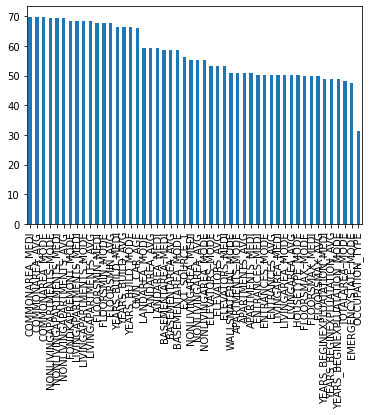

In [31]:
# 各列内の欠損の割合
(train.isnull().sum()/len(train)*100).sort_values(ascending = False)[:50].plot.bar()

## 特徴量重要度

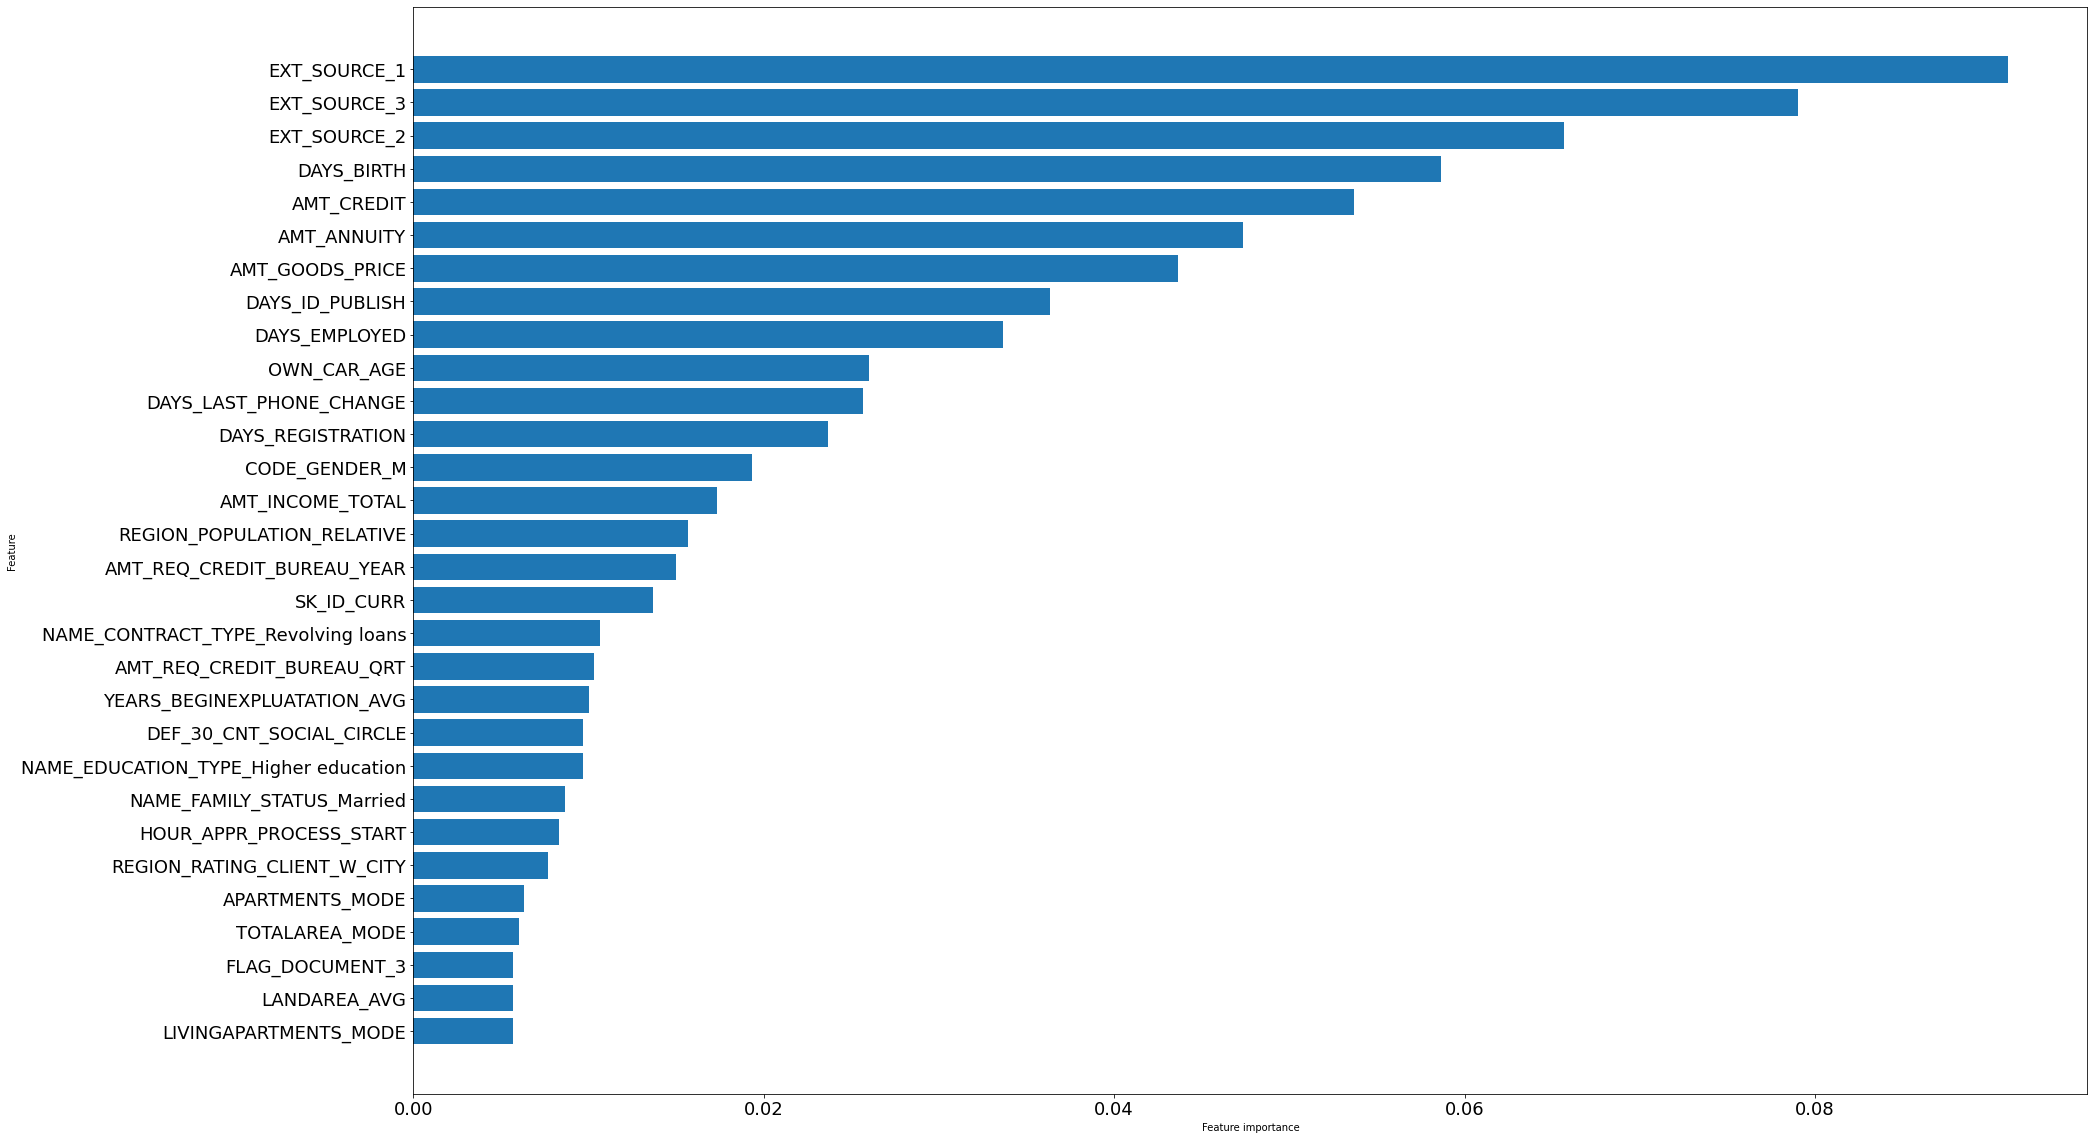

In [32]:
import lightgbm as lgb

X_tmp = train[train.columns[train.columns != 'TARGET']]
X_tmp = pd.get_dummies(X_tmp, drop_first=True)
y_tmp = train.TARGET

# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_tmp, y_tmp)

# LightGBM parameters
params = {
        'objective': 'binary', 
        'metric': 'auc', 
}

# モデルの学習
model = lgb.train(params, train_set=lgb_train)

# 描画関数
def plot_feature_importance(df): 
    n_features = len(df)                                # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')              # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values    # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values               # 特徴量の取得 
    
    plt.yticks(np.arange(n_features), cols_plot)        # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                    # x軸のタイトル
    plt.ylabel('Feature')                               # y軸のタイトル

# 算出
cols = list(X_tmp.columns)                              # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(model.feature_importance())     # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)      # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature': cols, 'importance': f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
#display(df_importance.head(20))

plt.figure(figsize=(30,20))
plt.tick_params(labelsize=18)
plot_feature_importance(df_importance.head(30))

#各特徴量

## target

In [33]:
# targetの分布
target = "TARGET"

print("TARGETの欠損値：", train[target].isnull().sum())
#print(train[target].value_counts())

posi = train[train["TARGET"]==1]
nega = train[train["TARGET"]==0]

print("返済が滞ったことがある人:", len(posi))
print("返済をしっかりしている人:", len(nega))

print("negaはposiの約", int(len(nega) / len(posi)), "倍のデータ数")

TARGETの欠損値： 0
返済が滞ったことがある人: 24825
返済をしっかりしている人: 282686
negaはposiの約 11 倍のデータ数


##EXT_SOURCE_1

欠損値: 173378
欠損値[%]: 56.381072546998325


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


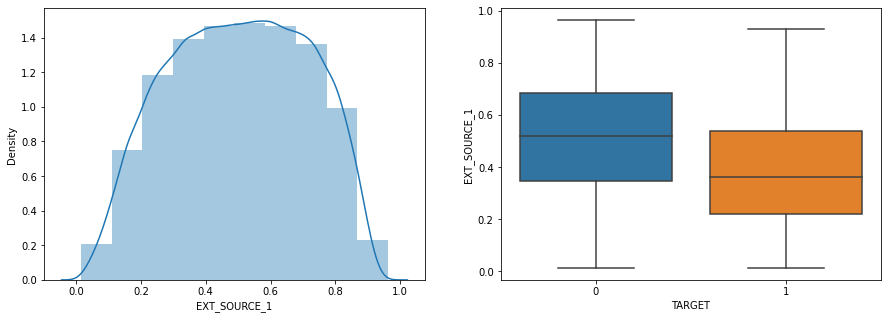

In [34]:
col = "EXT_SOURCE_1"
print("欠損値:", train[col].isnull().sum())
print("欠損値[%]:", train[col].isnull().sum()/ len(train) * 100)


fig, ax = plt.subplots(
        1, #縦の個数
        2, #横の個数
        figsize=(15, 5) #全体のサイズ(横,　縦)
)

# ヒストグラム
sns.distplot(train[col], bins=10, kde=True, ax=ax[0])

# targetとの箱髭図
sns.boxplot(x=target, y=train[col], data=train, ax=ax[1])

##EXT_SOURCE_2

欠損値: 660
欠損値[%]: 0.21462646864665005


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


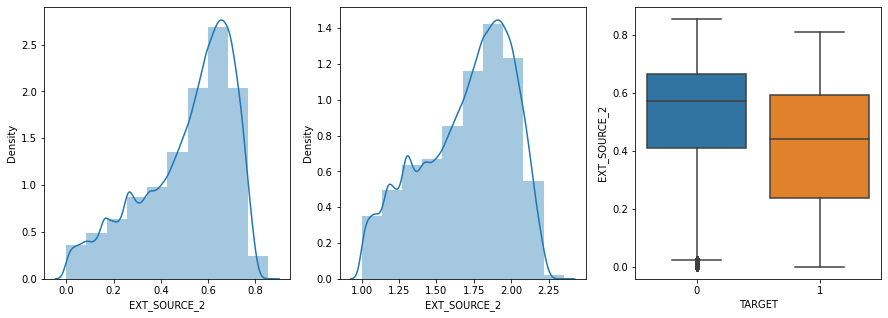

In [35]:
col = "EXT_SOURCE_2"
print("欠損値:", train[col].isnull().sum())
print("欠損値[%]:", train[col].isnull().sum()/ len(train) * 100)


fig, ax = plt.subplots(
        1, #縦の個数
        3, #横の個数
        figsize=(15, 5) #全体のサイズ(横,　縦)
)

# ヒストグラム
sns.distplot(train[col], bins=10, kde=True, ax=ax[0])
sns.distplot(np.exp(train[col]), bins=10, kde=True, ax=ax[1])

# targetとの箱髭図
sns.boxplot(x=target, y=train[col], data=train, ax=ax[2])

##EXT_SOURCE_3

欠損値: 60965
欠損値[%]: 19.825307062186393


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


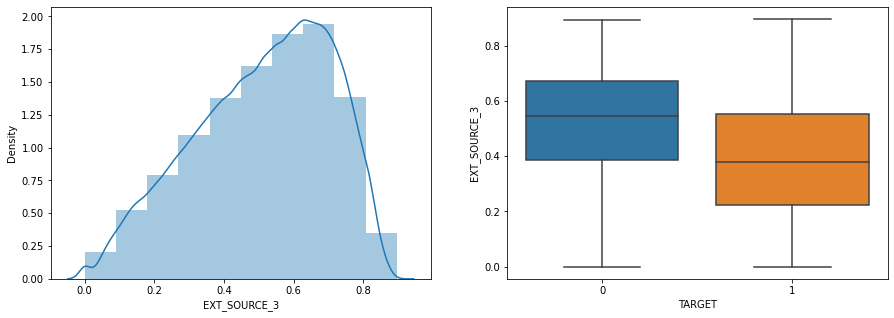

In [36]:
col = "EXT_SOURCE_3"
print("欠損値:", train[col].isnull().sum())
print("欠損値[%]:", train[col].isnull().sum()/ len(train) * 100)


fig, ax = plt.subplots(
        1, #縦の個数
        2, #横の個数
        figsize=(15, 5) #全体のサイズ(横,　縦)
)

# ヒストグラム
sns.distplot(train[col], bins=10, kde=True, ax=ax[0])

# targetとの箱髭図
sns.boxplot(x=target, y=train[col], data=train, ax=ax[1])

##DAYS_BIRTH

欠損値: 0
欠損値[%]: 0.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


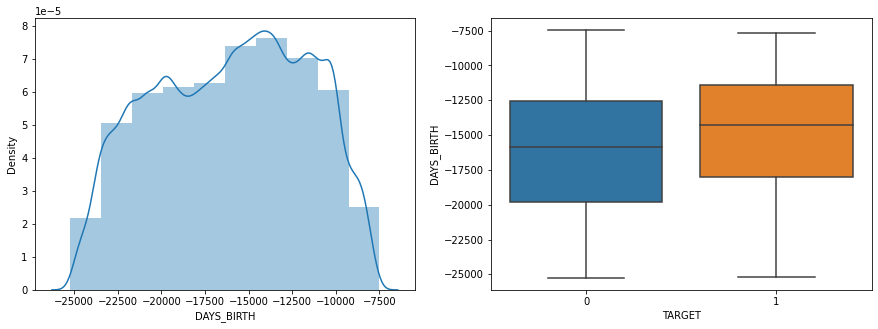

In [37]:
col = "DAYS_BIRTH"
print("欠損値:", train[col].isnull().sum())
print("欠損値[%]:", train[col].isnull().sum()/ len(train) * 100)


fig, ax = plt.subplots(
        1, #縦の個数
        2, #横の個数
        figsize=(15, 5) #全体のサイズ(横,　縦)
)

# ヒストグラム
sns.distplot(train[col], bins=10, kde=True, ax=ax[0])

# targetとの箱髭図
sns.boxplot(x=target, y=train[col], data=train, ax=ax[1])

##AMT_CREDIT

欠損値: 0
欠損値[%]: 0.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


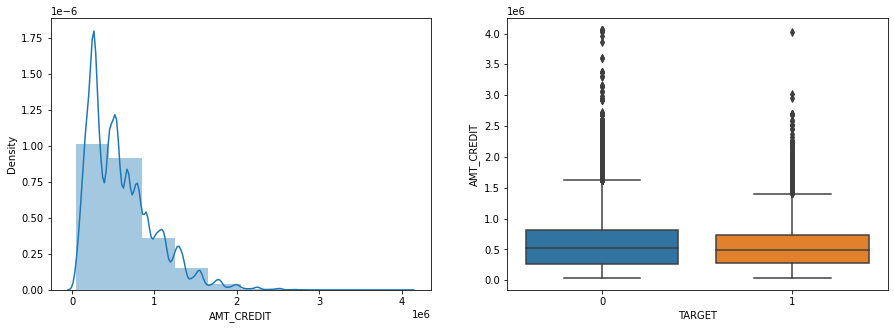

In [38]:
col = "AMT_CREDIT"
print("欠損値:", train[col].isnull().sum())
print("欠損値[%]:", train[col].isnull().sum()/ len(train) * 100)


fig, ax = plt.subplots(
        1, #縦の個数
        2, #横の個数
        figsize=(15, 5) #全体のサイズ(横,　縦)
)

# ヒストグラム
sns.distplot(train[col], bins=10, kde=True, ax=ax[0])

# targetとの箱髭図
sns.boxplot(x=target, y=train[col], data=train, ax=ax[1])

##AMT_ANNUITY

欠損値: 12
欠損値[%]: 0.003902299429939092


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


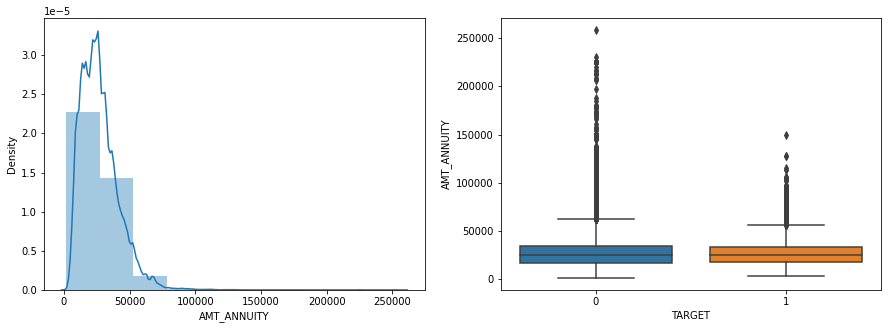

In [39]:
col = "AMT_ANNUITY"
# 年金
print("欠損値:", train[col].isnull().sum())
print("欠損値[%]:", train[col].isnull().sum()/ len(train) * 100)


fig, ax = plt.subplots(
        1, #縦の個数
        2, #横の個数
        figsize=(15, 5) #全体のサイズ(横,　縦)
)

# ヒストグラム
sns.distplot(train[col], bins=10, kde=True, ax=ax[0])

# targetとの箱髭図
sns.boxplot(x=target, y=train[col], data=train, ax=ax[1])

##DAYS_EMPLOYED

欠損値: 0
欠損値[%]: 0.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


64648

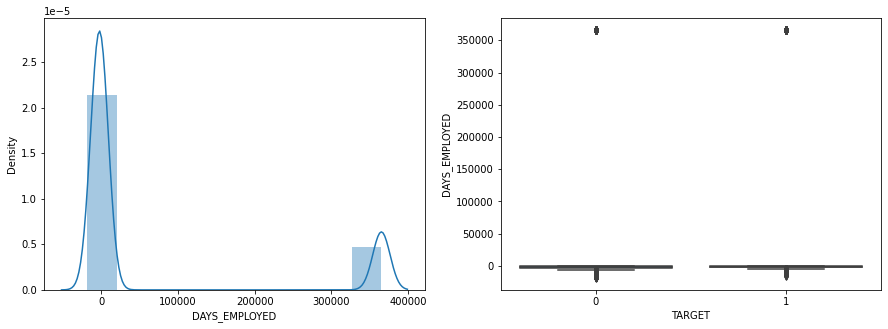

In [40]:
col = "DAYS_EMPLOYED"
print("欠損値:", train[col].isnull().sum())
print("欠損値[%]:", train[col].isnull().sum()/ len(train) * 100)

#print(train[col].value_counts()) # 365243は外れ値
#print(test[col].value_counts()) # 365243は外れ値

fig, ax = plt.subplots(
        1, #縦の個数
        2, #横の個数
        figsize=(15, 5) #全体のサイズ(横,　縦)
)

# ヒストグラム
sns.distplot(train[col], bins=10, kde=True, ax=ax[0])

# targetとの箱髭図
sns.boxplot(x=target, y=train[col], data=train, ax=ax[1])

# 外れ値の合計
9274+55374

#相関係数

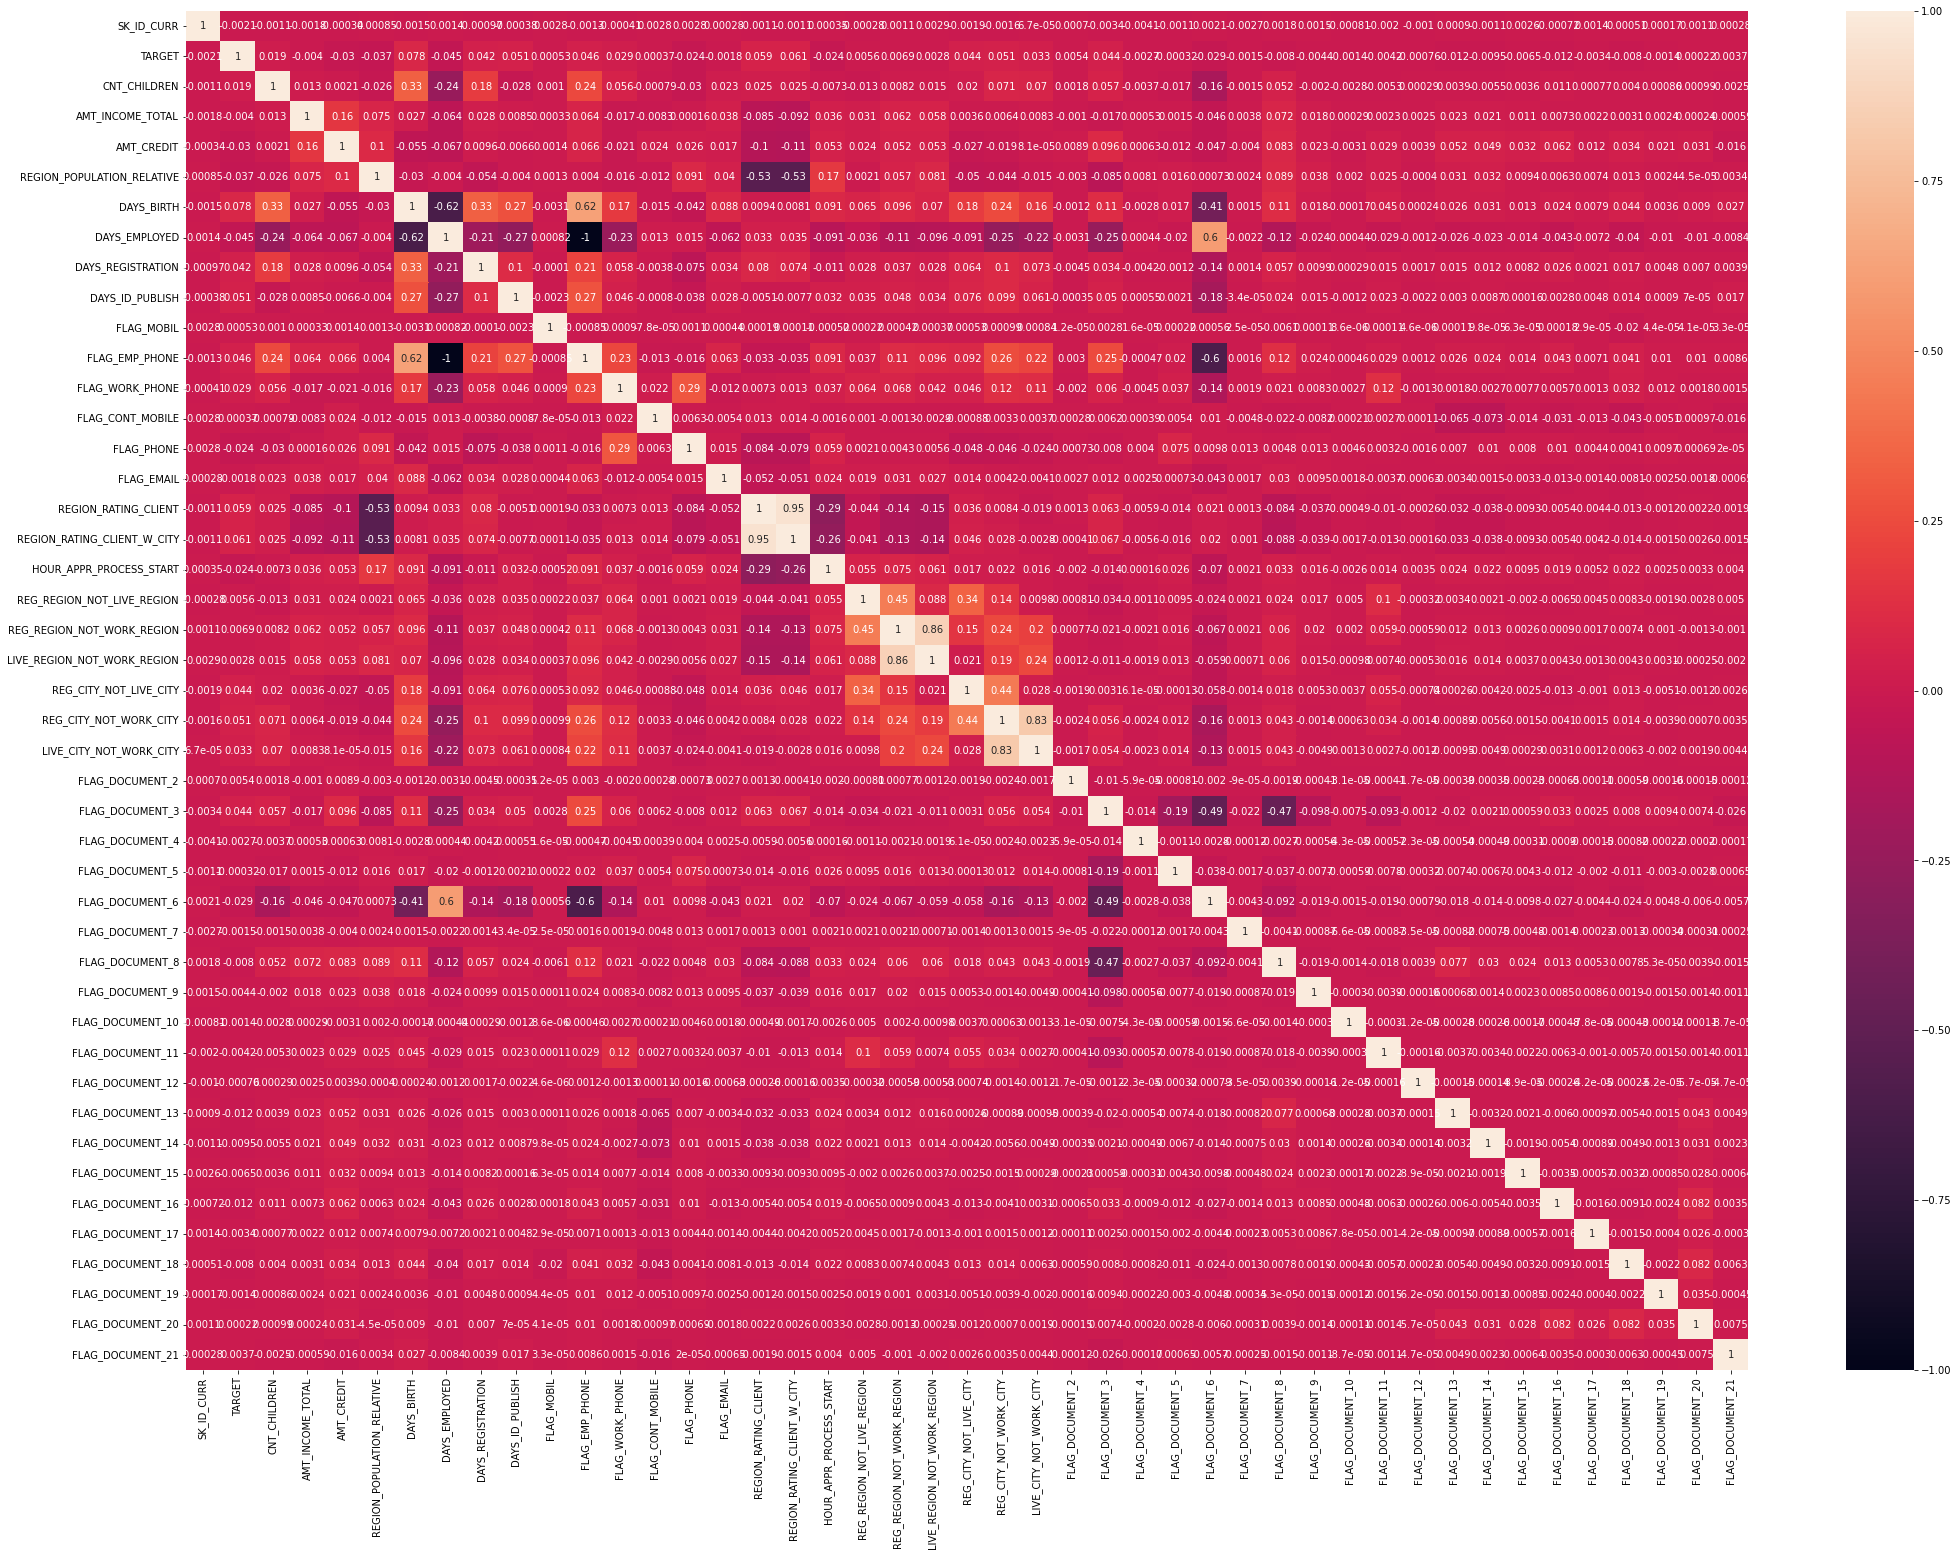

In [41]:
# 欠損値含まないカラムの相関係数
plt.figure(figsize=(35,25))
sns.heatmap(train.dropna(how='any', axis=1).corr(), annot=True, vmin=-1, vmax=1)

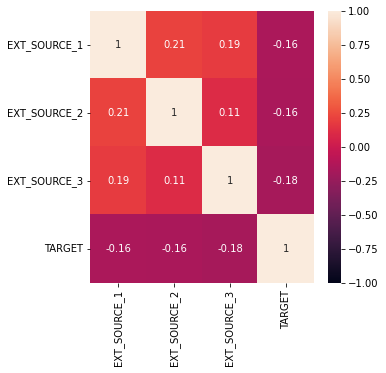

In [42]:
# EXT_SOURCEの相関係数
plt.figure(figsize=(5,5))
tmp = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "TARGET"]]
sns.heatmap(tmp.corr(), annot=True, vmin=-1, vmax=1)